## NIBRS Michigan and Collegiate Baseline Analysis ##

In this notebook, we'll work through some EDA of the NIBRS data for the State and campuses before combining with sports data to see what kinds of patterns exist.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
from matplotlib.dates import DateFormatter

As the data is quite large, We're using spark to assist with getting the dataset to a reasonable size.  

In [2]:
from pyspark.sql.types import DateType
from pyspark.sql.functions import col
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName('NIBRS') \
    .getOrCreate() 

sc = spark.sparkContext

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/30 15:57:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/04/30 15:57:25 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/04/30 15:57:25 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


There are 4 data files that we'll be using to combine into a dataset that can be paired with the college and football data.

In [3]:
inc = spark.read.csv('Data/Combined_Incidents.csv',header=True, inferSchema=True)
off = spark.read.csv('Data/Offenses.csv', header=True, inferSchema=True)
ag = spark.read.csv('Data/agencies.csv', header=True, inferSchema=True)
offtype = spark.read.csv('Data/off_types.csv',header=True, inferSchema=True)

In [4]:
# Let's take a look at the columns and data types that exist in all of the Spark DataFrames

print("Incidents", inc.dtypes)
print("Offences", off.dtypes)
print("Agencies", ag.dtypes)
print("Offense Types", offtype.dtypes)

Incidents [('DATA_YEAR', 'int'), ('AGENCY_ID', 'int'), ('INCIDENT_ID', 'int'), ('INCIDENT_DATE', 'string'), ('INCIDENT_HOUR', 'double')]
Offences [('YEAR', 'int'), ('OFFENSE_ID', 'int'), ('INCIDENT_ID', 'int'), ('OFFENSE_TYPE_ID', 'int')]
Agencies [('AGENCY_ID', 'int'), ('YEAR', 'int'), ('AGENCY_NAME', 'string'), ('COUNTY', 'string'), ('TYPE', 'string')]
Offense Types [('OFFENSE_TYPE_ID', 'int'), ('YEAR', 'int'), ('NAME', 'string'), ('AGAINST', 'string'), ('CATEGORY', 'string')]


In [5]:
# One of the biggest issues right off the bat is that the column for incident_date - a critical column - doesn't register as a date data type. 
inc = inc.withColumn('INCIDENT_DATE',col('INCIDENT_DATE').cast(DateType()))

In [6]:
# Let's create aliases/views of the dataframes so that we can use SQL to pull the data together.

inc.createOrReplaceTempView("inc")
off.createOrReplaceTempView("off")
ag.createOrReplaceTempView("ag")
offtype.createOrReplaceTempView('offtype')

### Michigan-Level Incident Analysis ###

Now that the data is in tables, we can use SQL to provide a more manageable dataset.  Let's look at the incidents across the State of Michigan over the 10-year period, looking at things like seasonality.

In [7]:
query = """

SELECT INCIDENT_DATE, COUNT(INCIDENT_ID) as INCIDENT_COUNT
FROM inc
GROUP BY INCIDENT_DATE
"""


result = spark.sql(query)


In [8]:
inc_cnt = result.toPandas()

I've creaeted a pandas dataframe from the result (a PySpark DataFrame).  The dataframe contains an aggregation of the number of incidents by date. 

In [9]:
inc_cnt.head()

,INCIDENT_DATE,INCIDENT_COUNT
0,2013-01-22,1107
1,2013-03-26,1484
2,2013-05-21,1633
3,2013-09-09,1517
4,2013-09-19,1504


In [10]:
inc_cnt.describe()

,INCIDENT_COUNT
count,3652.000000
mean,1392.749726
std,237.056614
min,576.000000
25%,1233.000000
50%,1389.000000
75%,1543.000000
max,2256.000000


On average, there are almost 1400 incidents reported across the state and given the fact that both the mean and the median are very close suggesting that this is approximating a normal distribution.

<AxesSubplot:xlabel='INCIDENT_COUNT', ylabel='Count'>

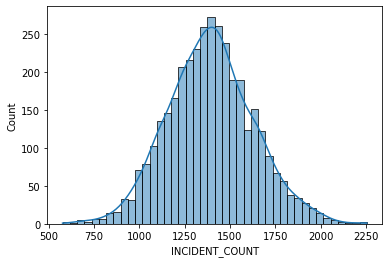

In [11]:
# Create a histogram with the x-axis representing the number of incidents (as defined by incident date).  The Y-axis will represent the number of times (aka the number of days) that a particular incident count was recorded over the
# 10 year period.
sns.histplot(x='INCIDENT_COUNT', data=inc_cnt, kde=True)

This looks very close to a normal distribution! Interpretation:  If we tally up on a daily basis, the number of incidents across MI, the distribution of the daily counts would be close to a normal one.

<AxesSubplot:title={'center':'Number of Incidents by Date (2010-2019) for Michigan'}, xlabel='INCIDENT_DATE'>

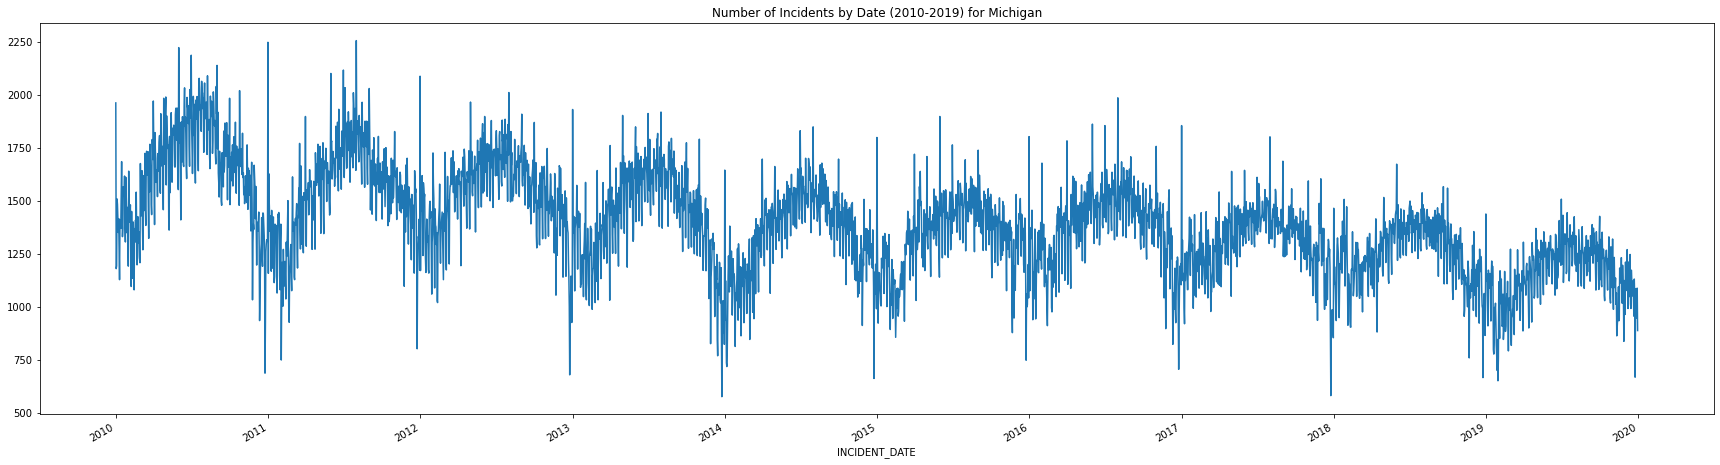

In [12]:
# We need to convert the incident date to a pandas datetime. In order for us to do a time-series, we need to change the dataframe to use a timeseries index
inc_cnt['INCIDENT_DATE'] = pd.to_datetime(inc_cnt['INCIDENT_DATE'])
inc_date = inc_cnt.set_index('INCIDENT_DATE')

fig, ax = plt.subplots(1)

inc_date.plot(figsize=(30,8), ax=ax, 
title="Number of Incidents by Date (2010-2019) for Michigan",legend=False)

Very interesting! We see a couple things looking at chart.  The first is that there appears to be a valley at the beginning of the year (corresponding to colder months) and peaks in the middle or near-middle of each year (warmer months).  The second observation is that there is a trend of decreasing incidents.  We can run descriptive statistics by year to validate that this is accurate as well as resample the times to make it a little easier (smoother) to see.

In [13]:
# Here I'm going to create a mini-datafrae that uses the datetime accessor to retrieve the year from the Incident Date and obtain descriptive statistics off the years.
years_desc = inc_cnt.groupby(inc_cnt['INCIDENT_DATE'].dt.year).describe().reset_index()
years_desc

INCIDENT_DATE INCIDENT_COUNT                                           \
                         count         mean         std    min      25%   
0          2010          365.0  1636.178082  243.349020  687.0  1460.00   
1          2011          365.0  1546.367123  229.530211  749.0  1421.00   
2          2012          366.0  1537.122951  195.568602  679.0  1440.25   
3          2013          365.0  1432.545205  220.625699  576.0  1303.00   
4          2014          365.0  1348.021918  196.079191  662.0  1228.00   
5          2015          365.0  1335.745205  173.696000  748.0  1230.00   
6          2016          366.0  1379.773224  179.784393  705.0  1278.50   
7          2017          365.0  1307.895890  152.827113  581.0  1230.00   
8          2018          365.0  1255.367123  146.630177  666.0  1170.00   
9          2019          365.0  1148.120548  147.050495  651.0  1055.00   

                            
      50%      75%     max  
0  1659.0  1810.00  2223.0  
1  1569.0  1689.00  2256.0  
2  1564.0  1668.00  2088.0  
3  1451.0  1606.00  1931.0  
4  1381.0  1488.00  1849.0  
5  1361.0  1449.00  1898.0  
6  1405.0  1499.75  1986.0  
7  1322.0  1407.00  1855.0  
8  1272.0  1360.00  1673.0  
9  1157.0  1262.00  1508.0

<AxesSubplot:xlabel='Year'>

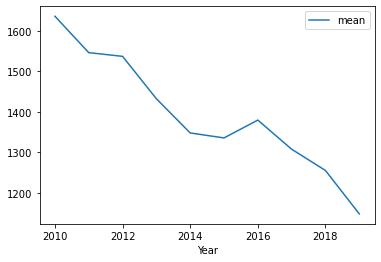

In [14]:
# We'll run a simple line graph (as a picture has less cognitive load compared to interpreting raw numbers)
years_desc.columns= ['Year', 'count','mean','std','min','25%','50%','75%','max']
years_desc.plot(x='Year', y='mean')

Here - it's a little easier to see the downward trend.  There does appear to be a bit of an increase in 2011 and also in 2016 but generally the trend is downward. Though we have the gist of the direction and cyclical nature of the incidences, we can make it easier to see the peaks and vallesy by using resampled data.  We'll create the lineplot by resampling incident counts over a month's length and summing the data which should reduce the exccess noise that we saw from mapping every date.

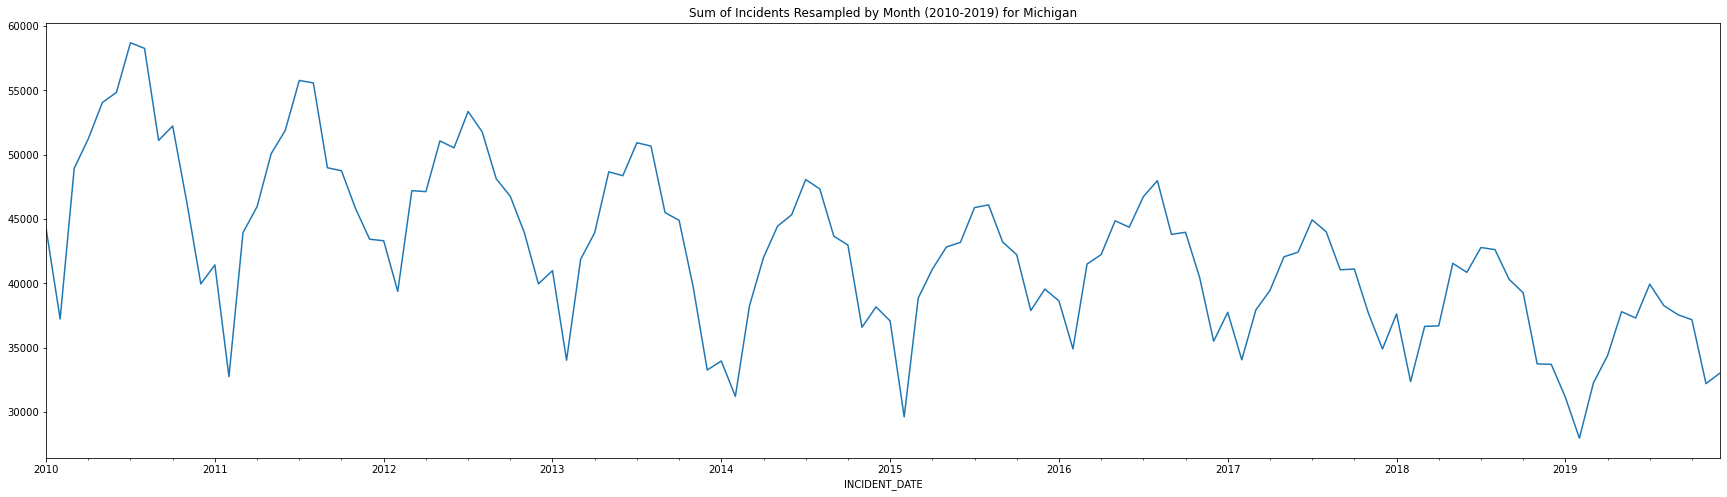

In [15]:
fig, ax = plt.subplots(1, sharex=True)

inc_date.resample('1M').sum().plot(figsize=(30,8), ax=ax, 
title="Sum of Incidents Resampled by Month (2010-2019) for Michigan",legend=False);

### Seasonality of Offenses ###

We're going to split the months up into categories relating to the 4 Seasons.  This isn't exact but anything that falls into the first 3 months of the year will be considered Winter, the next 3 will be Spring, next 3 Summer and so on.  

In [16]:
inc_date['Season'] = pd.cut(inc_date.index.month, bins=[0,3,6,9,12], labels=['Winter','Spring','Summer','Fall'])

In [17]:
inc_date.groupby('Season').describe()

INCIDENT_COUNT                                                    \
                count         mean         std     min      25%     50%   
Season                                                                    
Winter          902.0  1249.620843  202.776352   651.0  1116.00  1237.5   
Spring          910.0  1473.308791  204.407653   881.0  1333.00  1457.0   
Summer          920.0  1536.066304  202.783409  1079.0  1394.00  1512.5   
Fall            920.0  1310.078261  215.767624   576.0  1172.75  1318.0   

                         
            75%     max  
Season                   
Winter  1378.00  2248.0  
Spring  1615.50  2223.0  
Summer  1665.25  2256.0  
Fall    1459.00  2020.0

Interpretation: Counts here present the dates that we're counting.  The Mean represents the average number of crimes across the respective seasons over the 10 years and clearly shows what the graphs were telling us - that Summer experiences a higher number of incidents on average than the other months (with Spring coming in second followed by Fall).  This will need to be comprehended in our analysis of the effect on Crime as spring and summer sports. One caveat is that Football games start in the summer (in this case September). Let's see if we can understand what crimes are committed by Season by incorporating the associated offenses.

In [18]:
query1 = """

SELECT
i.INCIDENT_DATE, i.INCIDENT_ID, i.AGENCY_ID, ot.NAME

FROM
 inc i,
 off o,
 offtype ot
 
 
WHERE
o.INCIDENT_ID = i.INCIDENT_ID AND
o.OFFENSE_TYPE_ID = ot.OFFENSE_TYPE_ID

"""

result1 = spark.sql(query1)

### Baseline Analysis of Michigan/Michigan State Incidents ###

Now that we have an idea of what crime looks like in the State of Michigan, let's zoom into the two campuses.  Here, we don't want to talk about the sports events just yet, we want to understand what crime looks like across the two campuses. We can attribute which incident occurred for which campus by using the Agency ID as a proxy.  There are two primary agencies we'll be looking at: 9040 and 8554 for Michigan and Michigan State, respectively.


In [18]:
query2 = """

SELECT
INCIDENT_DATE, AGENCY_ID, COUNT(INCIDENT_ID) As INCIDENT_COUNTS

FROM
 inc i
 
WHERE
AGENCY_ID IN (9040,8554)

GROUP BY
    INCIDENT_DATE, AGENCY_ID
"""

result2 = spark.sql(query2)


In [19]:
uni_incs = result2.toPandas()

In [20]:
uni_incs['INCIDENT_DATE'] = pd.to_datetime(uni_incs["INCIDENT_DATE"])
uni_inc_dates = uni_incs.set_index('INCIDENT_DATE')

In [21]:
uni_inc_dates.columns = ['AGENCY_ID','INCIDENT_COUNTS']
uni_inc_dates = uni_inc_dates.groupby([uni_inc_dates.index, 'AGENCY_ID'])[['INCIDENT_COUNTS']].sum()

,INCIDENT_DATE,AGENCY_ID,INCIDENT_COUNTS
0,2013-09-20,9040,2
1,2013-10-30,9040,3
2,2013-10-09,9040,3
3,2013-08-01,9040,5
4,2013-10-22,9040,2
...,...,...,...
6436,2018-04-11,9040,3
6437,2018-10-10,9040,3
6438,2018-11-02,8554,3
6439,2018-07-01,8554,2


In [24]:
uni_inc_dates[uni_inc_dates.index.day_of_week==5][['MSU','UMICH']].sort_values('UMICH', ascending=False)

KeyError: "None of [Index(['MSU', 'UMICH'], dtype='object')] are in the [columns]"

AttributeError: 'DataFrame' object has no attribute 'INCIDENT_COUNTS'

In [143]:
uni_inc_dates.head()

INCIDENT_COUNTS
INCIDENT_DATE AGENCY_ID                 
2010-01-01    8554                     1
              9040                     6
2010-01-03    8554                     2
              9040                     1
2010-01-04    8554                     1

In [34]:
uni_inc_dates = uni_inc_dates.reset_index()
uni_inc_dates = uni_inc_dates.pivot(index='INCIDENT_DATE', columns='AGENCY_ID')

In [35]:
uni_inc_dates.head()

INCIDENT_COUNTS     
AGENCY_ID                8554 9040
INCIDENT_DATE                     
2010-01-01                1.0  6.0
2010-01-03                2.0  1.0
2010-01-04                1.0  NaN
2010-01-05                1.0  6.0
2010-01-06                1.0  5.0

In [36]:
uni_inc_dates.columns = ['MSU','UMICH']

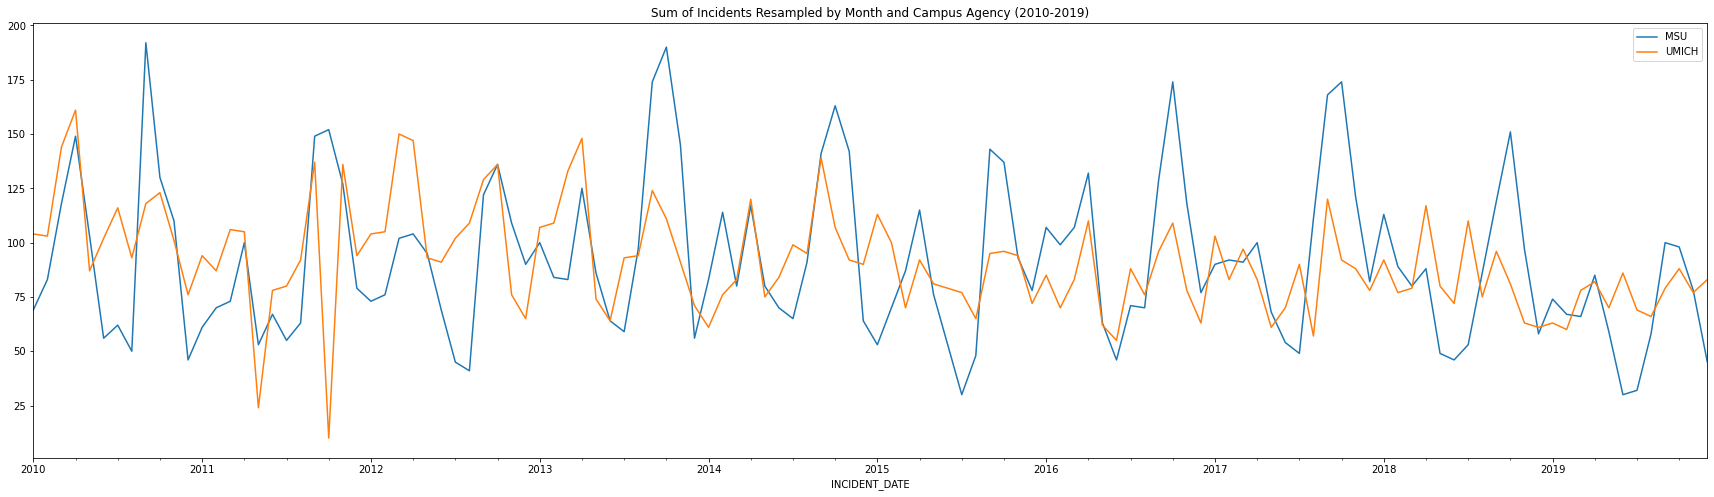

In [37]:
# fig, ax = plt.subplots(1, sharex=True)
uni_inc_dates.resample('1M').sum().plot(figsize=(30,8),

# uni_incs[['INCIDENT_COUNTS'].plot(figsize=(30,8), ax=ax, 
title="Sum of Incidents Resampled by Month and Campus Agency (2010-2019)",legend=True);

In [22]:
sql = """

SELECT i.INCIDENT_DATE, i.INCIDENT_HOUR, i.INCIDENT_ID, ot.NAME, i.AGENCY_ID


FROM 
    inc i,
    off o,
    ag a,
    offtype ot
    
WHERE
    o.INCIDENT_ID = i.INCIDENT_ID AND
    i.AGENCY_ID = a.AGENCY_ID AND
    o.OFFENSE_TYPE_ID = ot.OFFENSE_TYPE_ID AND
    i.AGENCY_ID IN (9040, 8554)
    
"""
result3 = spark.sql(sql)


In [23]:
offs = result3.toPandas()

In [24]:
offs.head()

,INCIDENT_DATE,INCIDENT_HOUR,INCIDENT_ID,NAME,AGENCY_ID
0,2013-01-10,21.0,69056266,Drug/Narcotic Violations,9040
1,2013-02-08,12.0,69057174,Theft From Building,9040
2,2013-03-07,20.0,69058152,Credit Card/Automated Teller Machine Fraud,9040
3,2013-05-29,10.0,69059921,All Other Larceny,9040
4,2013-05-28,12.0,69060846,Theft From Building,9040


In [25]:
offs['INCIDENT_DATE'] = pd.to_datetime(offs['INCIDENT_DATE'])
offs['Day'] = offs['INCIDENT_DATE'].dt.dayofweek

In [31]:
offs[offs['AGENCY_ID']==9040]

(11199, 6)

In [30]:
um_bar = alt.Chart().mark_bar().encode(
 x = alt.X('count(NAME):Q'),
 y = alt.Y('NAME:N')
)

um_bar


MaxRowsError: The number of rows in your dataset is greater than the maximum allowed (5000). For information on how to plot larger datasets in Altair, see the documentation

alt.Chart(...)

In [26]:
offs.Day = offs.Day.apply(lambda x: "Monday" if x==0 else "Tuesday" if x==1 else "Wednesday" if x==2 else "Thursday" if x==3 else "Friday" if x==4 else "Saturday" if x==5 else "Sunday")

In [27]:
offs

,INCIDENT_DATE,INCIDENT_HOUR,INCIDENT_ID,NAME,AGENCY_ID,Day
0,2013-01-10,21.0,69056266,Drug/Narcotic Violations,9040,Thursday
1,2013-02-08,12.0,69057174,Theft From Building,9040,Friday
2,2013-03-07,20.0,69058152,Credit Card/Automated Teller Machine Fraud,9040,Thursday
3,2013-05-29,10.0,69059921,All Other Larceny,9040,Wednesday
4,2013-05-28,12.0,69060846,Theft From Building,9040,Tuesday
...,...,...,...,...,...,...
22697,2018-05-29,12.0,99611144,Theft From Building,8554,Tuesday
22698,2018-10-02,16.0,101845969,Theft From Building,9040,Tuesday
22699,2018-11-15,20.0,101852509,Intimidation,9040,Thursday
22700,2018-03-16,0.0,98332305,Drug/Narcotic Violations,8554,Friday


In [29]:
offs.to_csv("Data/UM_MSU_Offs.csv",index=False)

In [71]:
grp_off = offs.groupby(['AGENCY_ID','Day','NAME']).describe().reset_index()

In [41]:
grp_off.columns = ['AGENCY_ID','Day','NAME','count','mean','std','min','25%','50%','75%','max']

In [72]:
grp_off
# grp_off.groupby(['AGENCY_ID','Day'], as_index=False).agg({'mean': 'max'}).merge(grp_off, how='inner', on=['AGENCY_ID','Day','mean'])

AGENCY_ID        Day                                         NAME  \
                                                                        
0        8554     Friday                           Aggravated Assault   
1        8554     Friday                            All Other Larceny   
2        8554     Friday                                        Arson   
3        8554     Friday                 Burglary/Breaking & Entering   
4        8554     Friday                       Counterfeiting/Forgery   
..        ...        ...                                          ...   
473      9040  Wednesday   Theft From Coin-Operated Machine or Device   
474      9040  Wednesday                     Theft From Motor Vehicle   
475      9040  Wednesday  Theft of Motor Vehicle Parts or Accessories   
476      9040  Wednesday                        Weapon Law Violations   
477      9040  Wednesday                                   Wire Fraud   

    INCIDENT_HOUR                                                       \
            count       mean        std  min    25%   50%    75%   max   
0            12.0   9.583333   8.764166  0.0   1.75   7.5  16.50  23.0   
1           480.0  13.877083   4.153060  0.0  11.00  14.0  16.25  23.0   
2             3.0   9.666667  10.598742  0.0   4.00   8.0  14.50  21.0   
3           119.0  12.991597   6.560663  0.0  10.00  14.0  18.00  23.0   
4             6.0  16.666667   5.006662  8.0  14.75  18.0  20.50  21.0   
..            ...        ...        ...  ...    ...   ...    ...   ...   
473           4.0   6.250000   6.130525  0.0   1.50   6.5  11.25  12.0   
474          71.0  11.901408   5.043114  0.0   8.00  12.0  16.00  20.0   
475           7.0  13.285714   4.889250  7.0  11.00  12.0  15.00  22.0   
476           5.0  10.000000   5.477226  1.0   9.00  12.0  13.00  15.0   
477           1.0   1.000000        NaN  1.0   1.00   1.0   1.00   1.0   

    INCIDENT_ID                                                         \
          count          mean           std          min           25%   
0          12.0  8.535432e+07  1.709330e+07   56569961.0  8.141326e+07   
1         480.0  7.497821e+07  1.587667e+07   56568010.0  6.698474e+07   
2           3.0  7.180621e+07  2.789217e+06   68585499.0  7.099998e+07   
3         119.0  7.462497e+07  1.477049e+07   56568074.0  6.015095e+07   
4           6.0  8.618378e+07  1.568669e+07   60149579.0  7.865255e+07   
..          ...           ...           ...          ...           ...   
473         4.0  6.586587e+07  2.129342e+06   64799398.0  6.480102e+07   
474        71.0  7.858559e+07  1.912966e+07   55980431.0  5.927400e+07   
475         7.0  7.390093e+07  1.579748e+07   55982415.0  6.252170e+07   
476         5.0  8.708230e+07  2.706978e+07   59276360.0  6.905805e+07   
477         1.0  1.028940e+08           NaN  102893952.0  1.028940e+08   

                                             
             50%           75%          max  
0     88184956.5  9.294468e+07  121215350.0  
1     68583740.0  8.690471e+07  119971132.0  
2     73414458.0  7.341656e+07   73418668.0  
3     73413615.0  8.483928e+07  117820548.0  
4     94351490.5  9.559669e+07   98818825.0  
..           ...           ...          ...  
473   64802096.5  6.586695e+07   69059881.0  
474   74955113.0  9.439911e+07  119966807.0  
475   69063545.0  8.685528e+07   93506620.0  
476   74953410.0  1.142857e+08  117837968.0  
477  102893952.0  1.028940e+08  102893952.0  

[478 rows x 19 columns]

22/04/24 23:40:42 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 598354 ms exceeds timeout 120000 ms
22/04/24 23:40:42 WARN SparkContext: Killing executors is not supported by current scheduler.


In [70]:
grp_off.describe(

AttributeError: module 'pandas' has no attribute 'Describe'